In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers import Input, Dense, Conv1D
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [ ]:
##################
# 데이터 load
##################
"""
 Original DataSet
 --  X.shape : (20631,24) / 'Y': 500개


ori_train = pd.read_csv('../data/train_FD0001_true5.csv',encoding= 'cp949')
#ori_test = pd.read_csv('./data/test_FD0001_true5.csv',encoding= 'cp949')
#data = pd.concat([ori_train,ori_test], axis = 0)
#data_X = data.iloc[:,:-1].values.tolist()
one_col = []
for i in range(2, ori_train.shape[1]-1):
    if len(np.unique(ori_train.iloc[:,i], axis=0)) == 1: one_col.append(i)

cols = list(range(2,ori_train.shape[1]-1))
cols = [x for x in cols if x not in one_col]
X_view = ori_train.iloc[:,cols]
X_view = pd.concat([ori_train.iloc[:,[0,1,-1]], X_view],axis=1)
X = ori_train.iloc[:,cols].values.tolist()
y = ori_train.iloc[:,-1]

###  scaling
scaled_X = preprocessing.StandardScaler().fit_transform(X)
#scaled_X = preprocessing.StandardScaler().fit_transform(test_seq)

#scaled_X = preprocessing.minmax_scale(train_seq)
data = pd.DataFrame(scaled_X,y)

X_train = data[data.index=='N']
X_train = np.expand_dims(X_train, axis=2)
X_train = np.transpose(X_train, (0,2,1))
print(X_train.shape)
#X_test = np.expand_dims(X_test, axis=2)
#X_test = np.transpose(X_test, (0,2,1))
#print(X_test.shape)

dataset = np.asarray(data)
dataset = np.expand_dims(dataset, axis=2)
dataset = np.transpose(dataset, (0,2,1))

X_reduce = pd.DataFrame()
X_reduce['x'] = [enco_train_re[x][0] for x in range(0,len(enco_train_re))]
X_reduce['y'] = [enco_train_re[x][1] for x in range(0,len(enco_train_re))]
X_reduce['label'] = data.index
"""

In [2]:
### sensor_data_increased load
root_path = './data/'

dataset = pd.read_excel(''.join([root_path,'haitian-kashui.xlsx']), encoding = 'CP94')
dataset = dataset[['CurrentTemp1','CurrentTemp2','CurrentTemp3', 'CurrentTemp4','CurrentTemp5','InjEndPosi','ClpOpnTime','ClpClsTime','ChargeTime','CycleTime','TurnPosi',
                    'TurnPress','label']]

X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]

###  scaling
scaled_X = preprocessing.minmax_scale(X)

# train, test split
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64.
  if sys.path[0] == '':


In [11]:
###시계열 데이터 load
train_seq = np.load('train_seq_60N_10out.npy')
train_seq_label = np.load('train_seq_label_60N_10out.npy')
train_seq2 = np.reshape(train_seq, (train_seq.shape[0], train_seq.shape[1]*train_seq.shape[2]))

# 정상 데이터만 학습
i, = np.where(train_seq_label==0)
X_train = train_seq[i]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_train.shape

(3322, 850)

In [7]:
### building Neural Net AutoEncoder
input_data = Input(shape=(X_train.shape[1],))

x = Dense(256, activation='relu')(input_data)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
nn_encoded = Dense(2, activation='sigmoid')(x)

x = Dense(16, activation='relu')(nn_encoded)
x = Dense(64, activation='relu')(x)
x = Dense(256, activation='relu')(x)
nn_decoded = Dense(X_train.shape[1], activation='sigmoid')(x)

nn_autoencoder = Model(input_data, nn_decoded)
nn_encoder = Model(input_data, nn_encoded)

nn_autoencoder.compile(loss='mse', optimizer='adadelta')
nn_encoder.compile(loss='mse', optimizer='adadelta')

In [8]:
nn_autoencoder.fit(X_train, X_train, epochs=30, shuffle=True, validation_split=0.05)

Train on 3155 samples, validate on 167 samples
Epoch 1/30
3155/3155 [==============================] - 2s 638us/step - loss: 1.0091 - val_loss: 0.5527
Epoch 2/30
3155/3155 [==============================] - 1s 423us/step - loss: 0.6774 - val_loss: 0.5317
Epoch 3/30
3155/3155 [==============================] - 1s 405us/step - loss: 0.6743 - val_loss: 0.5332
Epoch 4/30
3155/3155 [==============================] - 1s 399us/step - loss: 0.6741 - val_loss: 0.5312
Epoch 5/30
3155/3155 [==============================] - 1s 390us/step - loss: 0.6740 - val_loss: 0.5327
Epoch 6/30
3155/3155 [==============================] - 1s 379us/step - loss: 0.6739 - val_loss: 0.5321
Epoch 7/30
3155/3155 [==============================] - 1s 382us/step - loss: 0.6737 - val_loss: 0.5321
Epoch 8/30
3155/3155 [==============================] - 1s 411us/step - loss: 0.6737 - val_loss: 0.5310
Epoch 9/30
3155/3155 [==============================] - 1s 377us/step - loss: 0.6738 - val_loss: 0.5328
Epoch 10/30
3155/

In [12]:
auto_predict = nn_autoencoder.predict(train_seq2)

In [13]:
### calculate MSE
mse = mean_squared_error(train_seq2.T, auto_predict.T, multioutput='raw_values')
mse.shape

(5722,)

In [14]:
np.max(mse), np.min(mse) , np.mean(mse)

(3.38488517984876, 0.31350847154228473, 0.7776220759046671)

In [27]:
### labeling
# mse < border
border = 1.5
label= [0 if  mse[x] < border else 1 for x in range(0,len(mse)) ]
X_reduce = pd.DataFrame()
X_reduce['label'] = label
idx_0 = X_reduce[X_reduce.label == 0].index
idx_1 = X_reduce[X_reduce.label == 1].index
print(len(idx_0))
print(len(idx_1))

5319
403


In [28]:
np.sum(train_seq_label)

2400

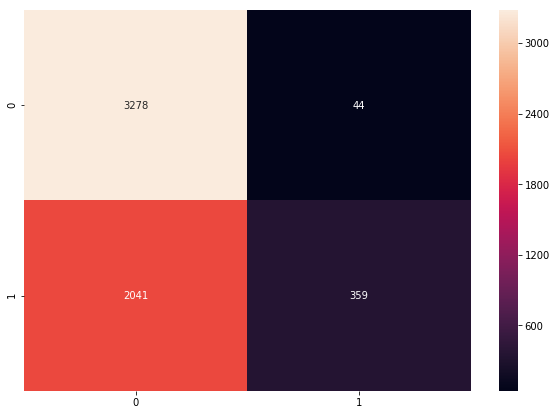

In [29]:
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(train_seq_label, X_reduce['label']))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, fmt='d')

#######################

In [6]:
pre_enco_X_train = pd.DataFrame(nn_encoder.predict(X_train))
pre_enco_X_test = pd.DataFrame(nn_encoder.predict(X_test))

In [7]:
pre_enco_X = pd.concat([pre_enco_X_train, pre_enco_X_test])

In [8]:
pre_enco_X.shape

(300, 2)

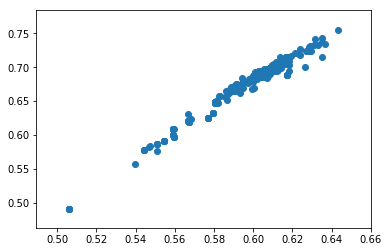

In [9]:
plt.scatter(pre_enco_X[0], pre_enco_X[1])

In [10]:
nn_predict = nn_autoencoder.predict(scaled_X)
print(nn_predict.shape)
### calculate MSE
mse = mean_squared_error(scaled_X.T, nn_predict.T, multioutput='raw_values')
print(mse.shape)

(300, 12)
(300,)


In [11]:
np.max(mse), np.min(mse) , np.mean(mse)

(0.15478984471784746, 0.0051131026917008195, 0.03963631722509937)

In [12]:
### labeling
# mse < border
border = 0.13

label= [0 if  mse[x] < border else 1 for x in range(0,len(mse)) ]
pre_enco_X['label'] = label
idx_0 = pre_enco_X[pre_enco_X.label == 0].index
idx_1 = pre_enco_X[pre_enco_X.label == 1].index
print(len(idx_0))
print(len(idx_1))

281
19


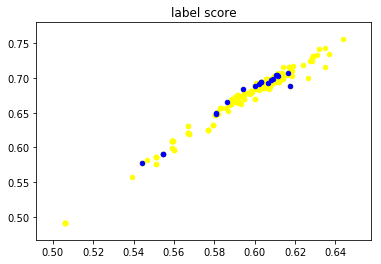

In [13]:
plt.title("label score")
# plt.xlim(-0.65, -0.3)
# plt.ylim(-3.5, -0.5)

b1 = plt.scatter(pre_enco_X.iloc[idx_0,0], pre_enco_X.iloc[idx_0,1], c='yellow',s=20)
b1 = plt.scatter(pre_enco_X.iloc[idx_1,0], pre_enco_X.iloc[idx_1,1], c='blue',s=20)

plt.show()

In [14]:
X_train2 = scaled_X[idx_0]

In [16]:
nn_autoencoder.fit(X_train2, X_train2, epochs=200, shuffle=True)

Epoch 1/200
281/281 [==============================] - 0s 57us/step - loss: 0.0347 - mean_squared_error: 0.0347
Epoch 2/200
281/281 [==============================] - 0s 53us/step - loss: 0.0347 - mean_squared_error: 0.0347
Epoch 3/200
281/281 [==============================] - 0s 50us/step - loss: 0.0347 - mean_squared_error: 0.0347
Epoch 4/200
281/281 [==============================] - 0s 50us/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 5/200
281/281 [==============================] - 0s 43us/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 6/200
281/281 [==============================] - 0s 53us/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 7/200
281/281 [==============================] - 0s 78us/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 8/200
281/281 [==============================] - 0s 46us/step - loss: 0.0346 - mean_squared_error: 0.0346
Epoch 9/200
281/281 [==============================] - 0s 71us/step - loss: 0.0346 - mean_squared_error:

281/281 [==============================] - 0s 53us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 145/200
281/281 [==============================] - 0s 46us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 146/200
281/281 [==============================] - 0s 61us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 147/200
281/281 [==============================] - 0s 60us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 148/200
281/281 [==============================] - 0s 46us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 149/200
281/281 [==============================] - 0s 50us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 150/200
281/281 [==============================] - 0s 57us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 151/200
281/281 [==============================] - 0s 68us/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 152/200
281/281 [==============================] - 0s 60us/step - loss: 0.0345 - mean_squared_er

In [17]:
pre_enco_X2 = pd.DataFrame(nn_encoder.predict(scaled_X))

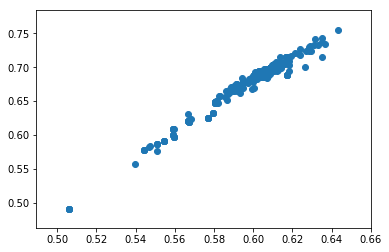

In [18]:
plt.scatter(pre_enco_X2[0], pre_enco_X2[1])

In [19]:
nn_predict2 = nn_autoencoder.predict(scaled_X)

### calculate MSE
mse2 = mean_squared_error(scaled_X.T, nn_predict2.T, multioutput='raw_values')
mse2.shape

(300,)

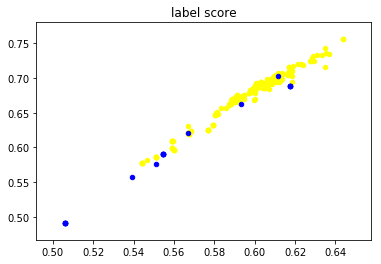

In [20]:
plt.title("label score")
# plt.xlim(-0.65, -0.3)
# plt.ylim(-3.5, -0.5)

b1 = plt.scatter(pre_enco_X2.iloc[idx_0,0], pre_enco_X2.iloc[idx_0,1], c='yellow',s=20)
b1 = plt.scatter(pre_enco_X2.iloc[idx_1,0], pre_enco_X2.iloc[idx_1,1], c='blue',s=20)

plt.show()

In [43]:
""" # for CNN-AE
X_train = np.expand_dims(scaled_X_train, axis=2)
#X_train = np.transpose(X_train, (0,2,1))  # shape: (201,1,12)
print(X_train.shape)
X_test = np.expand_dims(scaled_X_test, axis=2)
#X_test = np.transpose(X_test, (0,2,1))
print(X_test.shape)
"""

' # for CNN-AE\nX_train = np.expand_dims(scaled_X_train, axis=2)\n#X_train = np.transpose(X_train, (0,2,1))  # shape: (201,1,12)\nprint(X_train.shape)\nX_test = np.expand_dims(scaled_X_test, axis=2)\n#X_test = np.transpose(X_test, (0,2,1))\nprint(X_test.shape)\n'

In [61]:
"""
### building CNN AutoEncoder
input_data = Input(shape=X_train.shape[1:])

x = Conv1D(8, activation='relu', kernel_size=3, padding='same')(input_data)
x = Conv1D(8, activation='relu', kernel_size=3, padding='same')(x)
encoded = Conv1D(1, activation='relu', kernel_size=3, padding='same')(x)

x = Conv1D(4, activation='relu', kernel_size=3, padding='same')(encoded)
x = Conv1D(8, activation='relu', kernel_size=3, padding='same')(x)
x = Conv1D(8, activation='relu', kernel_size=3, padding='same')(x)
decoded = Conv1D(1, activation='sigmoid', kernel_size=3, padding='same')(x)

autoencoder = Model(input_data, decoded)
encoder = Model(input_data, encoded)

autoencoder.compile(loss='mse', optimizer='adadelta', metrics=['acc'])
encoder.compile(loss='mse', optimizer='adadelta', metrics=['acc'])
"""

"\n### building CNN AutoEncoder\ninput_data = Input(shape=X_train.shape[1:])\n\nx = Conv1D(8, activation='relu', kernel_size=3, padding='same')(input_data)\nx = Conv1D(8, activation='relu', kernel_size=3, padding='same')(x)\nencoded = Conv1D(1, activation='relu', kernel_size=3, padding='same')(x)\n\nx = Conv1D(4, activation='relu', kernel_size=3, padding='same')(encoded)\nx = Conv1D(8, activation='relu', kernel_size=3, padding='same')(x)\nx = Conv1D(8, activation='relu', kernel_size=3, padding='same')(x)\ndecoded = Conv1D(1, activation='sigmoid', kernel_size=3, padding='same')(x)\n\nautoencoder = Model(input_data, decoded)\nencoder = Model(input_data, encoded)\n\nautoencoder.compile(loss='mse', optimizer='adadelta', metrics=['acc'])\nencoder.compile(loss='mse', optimizer='adadelta', metrics=['acc'])\n"

In [57]:
# autoencoder.fit(X_train, X_train, epochs=50, batch_size=30, shuffle=True, validation_data=(X_test,X_test))

ValueError: Error when checking input: expected input_2 to have 3 dimensions, but got array with shape (201, 12)

In [93]:
predict = autoencoder.predict(X_test)

In [94]:
pre = predict.reshape(predict.shape[0],predict.shape[1])
pd.DataFrame(pre)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.301770,0.307754,0.974455,0.954399,0.959201,0.033175,0.016204,0.033440,0.964507,0.664705,0.095490,0.215278
1,0.726261,0.056697,0.978594,0.035323,0.978204,0.081806,0.978015,0.028475,0.970290,0.364185,0.757156,0.239528
2,0.899684,0.324525,0.020269,0.973940,0.040712,0.824761,0.977831,0.024309,0.546953,0.960000,0.233089,0.511328
3,0.894842,0.935090,0.024718,0.971034,0.045675,0.962249,0.040982,0.018914,0.028318,0.931362,0.691536,0.499342
4,0.311140,0.025057,0.946516,0.955089,0.035582,0.533291,0.035201,0.021823,0.031456,0.956362,0.585487,0.210148
5,0.061905,0.314478,0.952328,0.970122,0.022237,0.933699,0.956966,0.034047,0.017759,0.085974,0.387012,0.774167
6,0.056503,0.317731,0.950753,0.953238,0.035124,0.079888,0.050659,0.028272,0.043266,0.641002,0.386170,0.780428
7,0.725192,0.361122,0.974720,0.020678,0.319037,0.549725,0.022213,0.030632,0.530956,0.455094,0.535964,0.230920
8,0.751627,0.738204,0.970228,0.019846,0.020179,0.951414,0.967476,0.024134,0.540307,0.870628,0.142632,0.799001
9,0.059244,0.291537,0.975832,0.954599,0.967775,0.030681,0.959815,0.024452,0.021719,0.467908,0.486143,0.248947


In [95]:
xte = X_test.reshape(X_test.shape[0],X_test.shape[1])

In [96]:
pd.DataFrame(xte)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.333333,0.333333,1.0,1.0,1.000000,0.000000,0.0,0.0,1.0,0.565,0.153846,0.25
1,0.666667,0.000000,1.0,0.0,1.000000,0.083333,1.0,0.0,1.0,0.350,0.692308,0.25
2,1.000000,0.333333,0.0,1.0,0.000000,0.750000,1.0,0.0,0.5,0.985,0.230769,0.50
3,1.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,0.0,0.0,0.905,0.615385,0.50
4,0.333333,0.000000,1.0,1.0,0.000000,0.500000,0.0,0.0,0.0,0.990,0.538462,0.25
5,0.000000,0.333333,1.0,1.0,0.000000,0.916667,1.0,0.0,0.0,0.140,0.384615,0.75
6,0.000000,0.333333,1.0,1.0,0.000000,0.166667,0.0,0.0,0.0,0.590,0.384615,0.75
7,0.666667,0.333333,1.0,0.0,0.333333,0.500000,0.0,0.0,0.5,0.425,0.461538,0.25
8,0.666667,0.666667,1.0,0.0,0.000000,1.000000,1.0,0.0,0.5,0.820,0.153846,0.75
9,0.000000,0.333333,1.0,1.0,1.000000,0.000000,1.0,0.0,0.0,0.430,0.461538,0.25


In [113]:
# calculate MSE
mse = mean_squared_error(xte, pre, multioutput='raw_values')
#mse= pd.DataFrame(mse)

NameError: name 'xte' is not defined

In [98]:
np.max(mse), np.min(mse)

(0.005669226108518221, 0.0007409363609146242)

In [99]:
max = np.where(np.max(mse) == mse)

min = np.where(np.min(mse) == mse)

In [100]:
y_test.iloc[max]

468    1
Name: Label, dtype: int64

In [101]:
pd.concat([pd.DataFrame(xte[max[0][0]]), pd.DataFrame(pre[max[0][0]])], axis=1)

,0,0
0,1.000000,0.869401
1,1.000000,0.925622
2,0.000000,0.015675
3,0.000000,0.019368
4,0.666667,0.714116
5,0.750000,0.850754
6,0.000000,0.028686
7,0.000000,0.023948
8,1.000000,0.960070
9,0.135000,0.072229


In [102]:
y_test.iloc[min]

209    1
Name: Label, dtype: int64

In [103]:
pd.concat([pd.DataFrame(xte[min[0][0]]), pd.DataFrame(pre[min[0][0]])], axis=1)

,0,0
0,0.333333,0.314191
1,0.333333,0.315313
2,1.000000,0.975922
3,1.000000,0.965195
4,1.000000,0.969122
5,0.333333,0.344236
6,1.000000,0.964084
7,0.000000,0.029165
8,0.000000,0.017472
9,0.100000,0.072888


In [80]:
len(encoder.get_weights())

6

In [86]:
encoder.get_weights()[-2:]

[array([[[-0.21424773,  0.04533515, -0.28768528,  0.29664078],
         [-0.00526399, -0.22379772, -0.21529566, -0.12360813],
         [-0.13941297,  0.06189649,  0.03934465, -0.4098583 ],
         [ 0.04781438, -0.09604958,  0.37450454,  0.32453758],
         [-0.03474302,  0.2684814 ,  0.31649032,  0.09074331],
         [ 0.3946823 , -0.3937084 ,  0.15215352,  0.003958  ],
         [ 0.12796319, -0.12993824, -0.3792368 ,  0.07361583],
         [-0.1249005 , -0.1626768 , -0.24955514,  0.37470853]],
 
        [[-0.4927981 ,  0.30409318,  0.10986867, -0.29925615],
         [-0.04571893,  0.36102447,  0.16272712, -0.06718038],
         [-0.23299876,  0.08200877,  0.38244084,  0.17092888],
         [ 0.04849613, -0.2308329 ,  0.1146897 , -0.14610505],
         [ 0.12963744,  0.4392951 ,  0.95983243,  0.15810598],
         [-0.00863073, -0.06707119,  0.5717234 ,  0.10311729],
         [-0.5019806 , -0.26147023,  0.36253777,  0.14446145],
         [-0.38109443, -0.26008657, -0.31578547,  0.

In [40]:
np.linalg.norm(X_test-predict)

2.455413685793064

In [41]:
"""
from keras.optimizers import SGD
### building CNN model
learning_rate = 0.1
momentum = 0.85

# create model
model = Sequential()

# add model layers
model.add(Convolution1D(8, filter_length=3, activation='relu', border_mode='same', input_shape=(X_train.shape[1:])))
model.add(Convolution1D(4, filter_length=3, activation='relu', border_mode='same'))
model.add(Convolution1D(4, filter_length=3, activation='relu', border_mode='same'))
model.add(Flatten())
model.add(Dense(4, init='uniform', activation='relu'))
model.add(Dense(1, activation='softmax'))

sgd = SGD(lr=learning_rate, momentum=momentum)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc'])
model.fit(X_train, y_train, epochs=5, batch_size=128)
predictions = model.predict_proba(X_test)
"""

"\nfrom keras.optimizers import SGD\n### building CNN model\nlearning_rate = 0.1\nmomentum = 0.85\n\n# create model\nmodel = Sequential()\n\n# add model layers\nmodel.add(Convolution1D(8, filter_length=3, activation='relu', border_mode='same', input_shape=(X_train.shape[1:])))\nmodel.add(Convolution1D(4, filter_length=3, activation='relu', border_mode='same'))\nmodel.add(Convolution1D(4, filter_length=3, activation='relu', border_mode='same'))\nmodel.add(Flatten())\nmodel.add(Dense(4, init='uniform', activation='relu'))\nmodel.add(Dense(1, activation='softmax'))\n\nsgd = SGD(lr=learning_rate, momentum=momentum)\nmodel.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['acc'])\nmodel.fit(X_train, y_train, epochs=5, batch_size=128)\npredictions = model.predict_proba(X_test)\n"

In [42]:
"""
### plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

df_cm = pd.DataFrame(confusion_matrix(y_test, predictions))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)
"""

'\n### plot confusion matrix\nfrom sklearn.metrics import confusion_matrix\nimport matplotlib.pyplot as plt\nimport seaborn as sn\n%matplotlib inline\n\ndf_cm = pd.DataFrame(confusion_matrix(y_test, predictions))\nplt.figure(figsize=(10,7))\nsn.heatmap(df_cm, annot=True)\n'

In [120]:
enco_train_pred = nn_encoder.predict(X_train)
enco_test_pred = nn_encoder.predict(X_test)

enco_train_re = np.reshape(enco_train_pred,(len(enco_train_pred),2))
enco_test_re = np.reshape(enco_test_pred,(len(enco_test_pred),2))
enco_merge = np.concatenate((enco_train_re,enco_test_re), axis = 0)

X_reduce = pd.DataFrame()
X_reduce['x'] = [enco_merge[x][0] for x in range(0,len(enco_merge))]
X_reduce['y'] = [enco_merge[x][1] for x in range(0,len(enco_merge))]

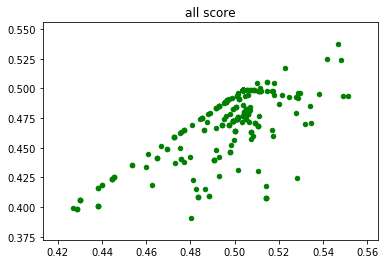

In [121]:
# 상무님 라벨

# true label
y = dataset.iloc[:,-1]

label1 = 1
label2 = 2
label3 = 3

# 전체
plt.title("all score")
# plt.xlim(-0.65, -0.3)
# plt.ylim(-3.5, -0.5)

b1 = plt.scatter(X_reduce['x'], X_reduce['y'], c='green',s=20)

plt.show()

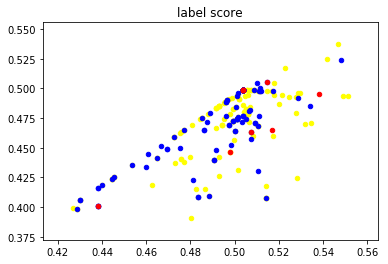

In [122]:
# 라벨별
idx_1 = y[y == label1 ].index.tolist()
idx_2 = y[y == label2 ].index.tolist()
idx_3 = y[y == label3 ].index.tolist()

plt.title("label score")
# plt.xlim(-0.65, -0.3)
# plt.ylim(-3.5, -0.5)

b1 = plt.scatter(X_reduce.iloc[idx_1,0], X_reduce.iloc[idx_1,1], c='yellow',s=20)
b1 = plt.scatter(X_reduce.iloc[idx_2,0], X_reduce.iloc[idx_2,1], c='blue',s=20)
b1 = plt.scatter(X_reduce.iloc[idx_3,0], X_reduce.iloc[idx_3,1], c='red',s=20)

plt.show()

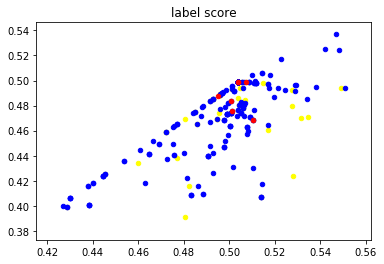

In [123]:
# k-means 라벨

# true label
y = pd.Series(np.load('./kashui_kmeans_label.npy'))

label1 = 0
label2 = 1
label3 = 2

# 라벨별
idx_1 = y[y == label1 ].index.tolist()
idx_2 = y[y == label2 ].index.tolist()
idx_3 = y[y == label3 ].index.tolist()

plt.title("label score")
# plt.xlim(-0.65, -0.3)
# plt.ylim(-3.5, -0.5)

b1 = plt.scatter(X_reduce.iloc[idx_1,0], X_reduce.iloc[idx_1,1], c='yellow',s=20)
b1 = plt.scatter(X_reduce.iloc[idx_2,0], X_reduce.iloc[idx_2,1], c='blue',s=20)
b1 = plt.scatter(X_reduce.iloc[idx_3,0], X_reduce.iloc[idx_3,1], c='red',s=20)

plt.show()

In [97]:
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

h=1
w=12
x_train = np.reshape(X_train,(len(X_train),h,w,1))
x_test = np.reshape(X_test,(len(X_test),h,w,1))

input_img = Input(shape=(h, w, 1)) # 1ch=black&white, 224 x 224

chanuel1 = 4
chanuel2 = 2

x = Convolution2D(chanuel1, 1, 3, activation='relu', border_mode='same')(input_img) #nb_filter, nb_row, nb_col
x = MaxPooling2D((1, 2), border_mode='same')(x)
x = Convolution2D(chanuel2, 1, 2, activation='relu', border_mode='same')(x)
x = MaxPooling2D((1, 2), border_mode='same')(x)
x = Convolution2D(1, 1, 2, activation='sigmoid', border_mode='same')(x)
encoded = MaxPooling2D((1, 2), border_mode='same')(x)

x = Convolution2D(chanuel2, 1, 2, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((1, 3))(x)
x = Convolution2D(chanuel1, 1, 2, activation='relu', border_mode='same')(x)
x = UpSampling2D((1, 1))(x)
x = Convolution2D(1, 1, 2, activation='relu', border_mode='same')(x)
x = UpSampling2D((1, 2))(x)
decoded = Convolution2D(1, 1, 3, activation='sigmoid', border_mode='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics = ['mse'])


autoencoder.fit(x_train, x_train, nb_epoch= 50, batch_size=50,             # nb_epoch 높으면 오래걸리니까 일단 2 나중에 50
               shuffle=True, validation_data=(x_test, x_test), verbose=1) 

C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((1, 2), padding="same")`
  app.launch_new_instance()
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(2, (1, 2), activation="relu", padding="same")`
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((1, 2), padding="same")`
C:\Users\ARA\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (1, 2), ac

Train on 240 samples, validate on 60 samples
Epoch 1/50
240/240 [==============================] - 1s 4ms/step - loss: 0.6931 - mean_squared_error: 0.0845 - val_loss: 0.6930 - val_mean_squared_error: 0.0891
Epoch 2/50
240/240 [==============================] - 0s 142us/step - loss: 0.6930 - mean_squared_error: 0.0845 - val_loss: 0.6929 - val_mean_squared_error: 0.0890
Epoch 3/50
240/240 [==============================] - 0s 175us/step - loss: 0.6929 - mean_squared_error: 0.0844 - val_loss: 0.6929 - val_mean_squared_error: 0.0890
Epoch 4/50
240/240 [==============================] - 0s 150us/step - loss: 0.6928 - mean_squared_error: 0.0844 - val_loss: 0.6928 - val_mean_squared_error: 0.0890
Epoch 5/50
240/240 [==============================] - 0s 142us/step - loss: 0.6927 - mean_squared_error: 0.0843 - val_loss: 0.6928 - val_mean_squared_error: 0.0889
Epoch 6/50
240/240 [==============================] - 0s 142us/step - loss: 0.6926 - mean_squared_error: 0.0843 - val_loss: 0.6927 - val_

In [98]:
encoder = Model(input_img, encoded)
encoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# encoder.save('./result/encoder.h5')

enco_train_pred = encoder.predict(x_train)
enco_test_pred = encoder.predict(x_test)

enco_train_re = np.reshape(enco_train_pred,(len(enco_train_pred),2))
enco_test_re = np.reshape(enco_test_pred,(len(enco_test_pred),2))
enco_merge = np.concatenate((enco_train_re,enco_test_re), axis = 0)

X_reduce = pd.DataFrame()
X_reduce['x'] = [enco_merge[x][0] for x in range(0,len(enco_merge))]
X_reduce['y'] = [enco_merge[x][1] for x in range(0,len(enco_merge))]